In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mp

deg2rad = np.deg2rad


def mph2mps(x: float) -> float:
    return x * 0.44704


def m2y(x: float) -> float:
    return x * 1.09361


def s2lr(x: str) -> float:
    return "L" if x < 0 else "R" if x > 0 else ""


def lr2s(x: str) -> float:
    if x.startswith("L"):
        return -float(x[1:])
    elif x.startswith("R"):
        return float(x[1:])
    return float(x)

In [14]:
# https://link.springer.com/article/10.1007/s12283-020-0318-1

from dataclasses import dataclass, field

from golf import Projectile, Vector

AIR_DENSITY = 1.22  # kg/m^3
AIR_KINEMATIC_VISCOSITY = 1.46e-5  # m^2/s
GRAVITY = Vector((0, -9.80665, 0))  # m/s^2


@dataclass(kw_only=True)
class GolfBall(Projectile):
    """Simulates golf ball motion."""
    
    spin_rate: float = 0
    spin_axis: Vector = field(default_factory=lambda: Vector((0, 0, 1)))
    spin_decay: float = 0.04
    radius: float = 0.04267 / 2
    mass: float = 0.04593
    drag_coefficient: float = 0.2  # 0.21 to 0.26
    lift_coefficient: float = 0.14  # 0.14 to 0.19
    
    @property
    def spin_axis_unit(self) -> Vector:
        return self.spin_axis / np.linalg.norm(self.spin_axis)
    
    @property
    def cross_sectional_area(self) -> float:
        return np.pi * self.radius ** 2
    
    def project(self, delta: float, v: Vector, x: Vector) -> Vector:
        A = self.cross_sectional_area
        spin_axis_unit = self.spin_axis_unit
        
        speed = np.linalg.norm(v)
        v_unit = v / speed
        
        Re = speed * self.radius * 2 / AIR_KINEMATIC_VISCOSITY
        if Re < 100_000:    
            C_D = 1.29e-10 * Re ** 2 - 2.59e-5 * Re + 1.5
        else:
            C_D = 1.91e-11 * Re ** 2 - 5.40e-6 * Re + 0.56
        drag = (
            0.5
            * C_D
            * AIR_DENSITY
            * A
            * speed * speed
            * -v_unit
            / self.mass
        )

        S = self.spin_rate * self.radius / speed
        C_L = -3.25 * S**2 + 1.99 * S

        lift = (
            0.5
            * C_L
            * AIR_DENSITY
            * A
            * speed * speed
            * np.cross(spin_axis_unit, v_unit)
            / self.mass
        )

        return GRAVITY + drag + lift
    
    def update(self, delta: float, velocity: Vector, position: Vector) -> None:
        self.spin_rate -= self.spin_rate * self.spin_decay * delta
        pass


def golf(
    ball_speed_mph: float,
    launch_direction_deg: float,  # negative is left
    launch_angle_deg: float,
    spin_rate_rpm: float,
    spin_axis_deg: float,  # negative is left
    delta: float = 0.01,
    summarize: bool = False,
    plot: mp.figure.Figure | None = None,
    plot_color: str | None = None,
    **kwargs: object,
) -> list[Vector]:
    """Create a new golf ball projectile from imperial data."""
    
    ball_speed = mph2mps(ball_speed_mph)
    launch_direction = deg2rad(launch_direction_deg)
    launch_angle = deg2rad(launch_angle_deg)
    spin_rate = deg2rad(spin_rate_rpm / 60 * 360)
    spin_axis = deg2rad(spin_axis_deg)

    ball = GolfBall(
        spin_rate=spin_rate,
        spin_axis=Vector((0, -np.sin(spin_axis), np.cos(spin_axis))),
        **kwargs,
    )

    velocity = Vector((
        ball_speed * np.cos(launch_angle) * np.cos(launch_direction),
        ball_speed * np.sin(launch_angle),
        ball_speed * np.sin(launch_direction),
    ))

    simulation = ball.simulate(delta, velocity=velocity, position=Vector((0, 0, 0)))
    positions = []
    for time, velocity, position in simulation:
        if position[1] < 0:
            break
        positions.append(position)

    if plot:
        xs = [p[0] for p in positions]
        ys = [p[2] for p in positions]
        zs = [p[1] for p in positions]
        plot.plot(xs, ys, zs, c=plot_color)

    if summarize:
        carry = positions[-1][0]
        offline = positions[-1][2]
        apex = max(p[1] for p in positions)
        print(f"Carry: {m2y(carry):.2f} yards")
        print(f"Offline: {s2lr(offline)}{m2y(abs(offline)):.2f} yards")
        print(f"Apex: {m2y(apex):.2f} yards")

    return positions

Carry: 269.94 yards
Offline: R10.27 yards
Apex: 40.35 yards
Carry: 65.89 yards
Offline: R0.06 yards
Apex: 16.08 yards


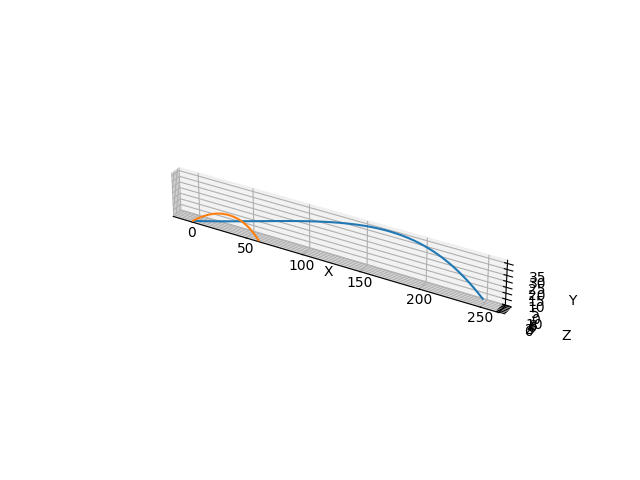

In [15]:
%matplotlib widget

import matplotlib.pyplot as plt

figure = plt.figure()
subplot = figure.add_subplot(projection="3d")

# Carry: 251.4
# Offline: L1.5
# Apex: 37.5
golf(
    ball_speed_mph=150.7,
    launch_direction_deg=1.2,
    launch_angle_deg=13.9,
    spin_rate_rpm=2776,
    spin_axis_deg=1.7,
    summarize=True,
    plot=subplot,
    plot_color="C0",
)

# Carry: 89.2
# Offline: 0.1
# Apex: 30.9
golf(
    ball_speed_mph=80.2,
    launch_direction_deg=0.2,
    launch_angle_deg=37.7,
    spin_rate_rpm=10175,
    spin_axis_deg=0.7,
    summarize=True,
    plot=subplot,
    plot_color="C1",
)

# golf(
#     ball_speed_mph=160,
#     launch_direction_deg=0,
#     launch_angle_deg=6,
#     spin_rate_rpm=3000,
#     spin_axis_deg=0,
#     summarize=True,
#     plot=subplot,
#     plot_color="C1",
# )

subplot.set_xlabel("X")
subplot.set_ylabel("Z")
subplot.set_zlabel("Y")
subplot.axis("scaled")
plt.show()

In [16]:
data = pd.read_csv("data/20250511-DrivingRange.csv", skiprows=1)
data = data[data["Index"].str.isnumeric()]
data = data.replace({"G-Wedge": "50º", "S-Wedge": "55º", "L-Wedge": "60º"})

Apex RSS: 6379.17
Carry RSS: 19882.94
Offline RSS: 2007.89
Total RSS: 28270.00


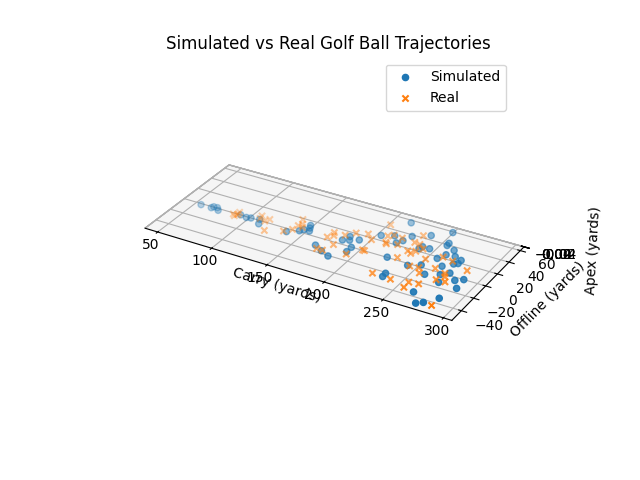

In [17]:
%matplotlib widget

simulated = []
real = []

apex_rss: float = 0
carry_rss: float = 0
offline_rss: float = 0

for i in data.index:
    ball_speed_mph = data["Ball Speed(mph)"][i]
    launch_direction_deg = lr2s(data["Launch Direction"][i])
    launch_angle_deg = data["Launch Angle"][i]
    spin_rate_rpm = data["Spin Rate"][i]
    spin_axis_deg = lr2s(data["Spin Axis"][i])
    
    positions = golf(
        ball_speed_mph=ball_speed_mph,
        launch_direction_deg=launch_direction_deg,
        launch_angle_deg=launch_angle_deg,
        spin_rate_rpm=spin_rate_rpm,
        spin_axis_deg=spin_axis_deg,
    )
    
    simulated_apex = m2y(max(p[1] for p in positions))
    simulated_carry = m2y(positions[-1][0])
    simulated_offline = m2y(positions[-1][2])
    simulated.append((simulated_apex, simulated_carry, simulated_offline))
    
    real_apex = data["Apex(yd)"][i]
    real_carry = data["Carry(yd)"][i]
    real_offline = lr2s(data["Offline(yd)"][i])
    real.append((real_apex, real_carry, real_offline))

    apex_rss += (real_apex - simulated_apex) ** 2
    carry_rss += (real_carry - simulated_carry) ** 2
    offline_rss += (real_offline - simulated_offline) ** 2

print(f"Apex RSS: {apex_rss:.2f}")
print(f"Carry RSS: {carry_rss:.2f}")
print(f"Offline RSS: {offline_rss:.2f}")
print(f"Total RSS: {apex_rss + carry_rss + offline_rss:.2f}")

figure = plt.figure()
subplot = figure.add_subplot(projection="3d")
subplot.scatter(
  [p[1] for p in simulated],
  [p[2] for p in simulated],
  [0 for p in simulated],  # [p[0] for p in compare]
  c="C0",
  marker="o",
  label="Simulated",
)
subplot.scatter(
  [p[1] for p in real],
  [p[2] for p in real],
  [0 for p in real],  # [p[3] for p in compare]
  c="C1",
  marker="x",
  label="Real",
)
subplot.set_xlabel("Carry (yards)")
subplot.set_ylabel("Offline (yards)")
subplot.set_zlabel("Apex (yards)")
subplot.axis("scaled")
subplot.legend()
plt.title("Simulated vs Real Golf Ball Trajectories")
plt.show()

In [6]:
plt.close()